# setup

In [1]:
!pip install transformers==4.38.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 25.4 MB/s eta 0:00:00


In [2]:
!pip install datasets evaluate accelerate eyecite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.8/168.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/projects/us_supreme_court

/content/drive/MyDrive/projects/us_supreme_court


In [5]:
from utils.pre_train import *
from utils.notebook_utils import *

%load_ext autoreload
%autoreload 2

# Read from Hub

In [6]:
import os
from huggingface_hub import notebook_login
notebook_login()

In [7]:
dataset = load_dataset("raminass/opinions-94-23")
opinions = pd.DataFrame(dataset["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4619 [00:00<?, ? examples/s]

In [ ]:
opinions.author.value_counts()

Thomas        571
Scalia        473
Breyer        443
Stevens       407
Ginsburg      390
Kennedy       326
Alito         286
Souter        230
Sotomayor     226
Gorsuch       168
O'Connor      167
Kavanaugh     160
Kagan         145
Rehnquist     144
per_curiam    140
Roberts       123
Barrett       122
Jackson        98
Name: author, dtype: int64

# Filter Data

In [8]:
opinions=opinions[opinions.author!='per_curiam']

In [ ]:
# opinions = opinions[~opinions.author.isin(['Jackson', 'Barrett'])] # 15 model
# opinions = opinions[~opinions.author.isin(['Jackson', 'Barrett', 'Kavanaugh'])] # 14 model

In [ ]:
opinions.type.value_counts()

majority      2304
dissenting    1327
concurring     848
Name: type, dtype: int64

In [ ]:
opinions.author.value_counts()

Thomas       571
Scalia       473
Breyer       443
Stevens      407
Ginsburg     390
Kennedy      326
Alito        286
Souter       230
Sotomayor    226
Gorsuch      168
O'Connor     167
Kavanaugh    160
Kagan        145
Rehnquist    144
Roberts      123
Barrett      122
Jackson       98
Name: author, dtype: int64

# Add Labels

In [9]:
id2label, label2id = get_labels_maping(opinions)

In [10]:
opinions["label"] = opinions["author"].map(label2id)

In [ ]:
opinions.sample(3)

,case_name,text,year,author,type,clean_text,label
4153,Miller v. Alabama,I join the Court’s opinion in full. I add that...,2012,Breyer,concurring,I join the Court’s opinion in full. I add that...,5
2058,Puerto Rico v. Sanchez Valle,"I join in full the Court’s opinion, which coge...",2016,Ginsburg,concurring,"I join in full the Court’s opinion, which coge...",11
2895,Day v. McDonough,The Court today disregards the Federal Rules o...,2006,Scalia,dissenting,The Court today disregards the Federal Rules o...,12


In [ ]:
import json
with open("data/j_year.json", "r") as j:
    judges_by_year = json.loads(j.read())
labels_by_year = {k: [label2id[item] for item in v] for k,v in judges_by_year.items()}

# Train-Test

In [11]:
from sklearn.model_selection import train_test_split
opinions_train, opinions_test = train_test_split(opinions, random_state=2024, test_size=0.2, stratify=opinions['label'])
# opinions_train, opinions_test = train_test_split(opinions, test_size=0.2, stratify=opinions['label'])

In [ ]:
opinions_test.author.value_counts()

Thomas       114
Scalia        95
Breyer        89
Stevens       81
Ginsburg      78
Kennedy       65
Alito         57
Souter        46
Sotomayor     45
Gorsuch       34
O'Connor      33
Kavanaugh     32
Rehnquist     29
Kagan         29
Roberts       25
Barrett       24
Jackson       20
Name: author, dtype: int64

In [ ]:
opinions_train.author.value_counts()

Thomas       457
Scalia       378
Breyer       354
Stevens      326
Ginsburg     312
Kennedy      261
Alito        229
Souter       184
Sotomayor    181
O'Connor     134
Gorsuch      134
Kavanaugh    128
Kagan        116
Rehnquist    115
Roberts       98
Barrett       98
Jackson       78
Name: author, dtype: int64

# Split Paragraphs

In [12]:
par_train = split_data(opinions_train, id2label, label2id)
par_test = split_data(opinions_test, id2label, label2id)

In [ ]:
par_train.author.value_counts()

Thomas       3998
Breyer       3420
Scalia       3334
Kennedy      3072
Alito        2920
Ginsburg     2833
Stevens      2271
Sotomayor    2037
Souter       1750
Kagan        1542
O'Connor     1296
Jackson      1214
Gorsuch      1206
Roberts      1124
Kavanaugh    1100
Rehnquist     848
Barrett       745
Name: author, dtype: int64

In [ ]:
par_test.author.value_counts()

Breyer       960
Thomas       941
Kennedy      910
Ginsburg     756
Scalia       751
Alito        662
Stevens      569
Sotomayor    496
Souter       466
Kagan        371
O'Connor     365
Gorsuch      352
Roberts      327
Kavanaugh    275
Rehnquist    237
Jackson      220
Barrett      176
Name: author, dtype: int64

In [ ]:
# par_train = par_train.groupby('author',as_index = False,group_keys=False).apply(lambda s: s.sample(2000, replace=len(s)<2000))

In [ ]:
par_train.author.value_counts()

Thomas       3998
Breyer       3420
Scalia       3334
Kennedy      3072
Alito        2920
Ginsburg     2833
Stevens      2271
Sotomayor    2037
Souter       1750
Kagan        1542
O'Connor     1296
Jackson      1214
Gorsuch      1206
Roberts      1124
Kavanaugh    1100
Rehnquist     848
Barrett       745
Name: author, dtype: int64

In [ ]:
# par_test = par_test.groupby('author',as_index = False,group_keys=False).apply(lambda s: s.sample(400, replace=len(s)<400))

In [ ]:
par_test.author.value_counts()

Breyer       960
Thomas       941
Kennedy      910
Ginsburg     756
Scalia       751
Alito        662
Stevens      569
Sotomayor    496
Souter       466
Kagan        371
O'Connor     365
Gorsuch      352
Roberts      327
Kavanaugh    275
Rehnquist    237
Jackson      220
Barrett      176
Name: author, dtype: int64

# Model

In [13]:
from utils import train
from transformers import set_seed
set_seed(1010)

In [14]:
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()
ds_dict = {
        "train": Dataset.from_pandas(
            par_train[["label", "text"]], preserve_index=False
        ),
        "test": Dataset.from_pandas(
            par_test[["label", "text"]], preserve_index=False
        ),
    }
ds = DatasetDict(ds_dict)
tokenized_court = train.tokenize_dataset(ds)

In [15]:
 trainer = train.get_trainer(
        id2label,
        label2id,
        tokenized_court,
        epochs=3,
        model_name=f"M10",
        batch_size=16,
        push_to_hub=True,
    )
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at raminass/scotus-v10 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([13, 512]) in the checkpoint and torch.Size([17, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([13]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_samp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.796400,0.984199,0.710324
2,0.444700,0.922224,0.737831
3,0.271900,0.926026,0.743604


TrainOutput(global_step=6510, training_loss=0.6404177886549778, metrics={'train_runtime': 3074.2483, 'train_samples_per_second': 33.872, 'train_steps_per_second': 2.118, 'total_flos': 6137584409548800.0, 'train_loss': 0.6404177886549778, 'epoch': 3.0})

In [16]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/raminass/M10/commit/bfa65b8d2af7ab9d70f3e841eaf5fac3c4cf74e7', commit_message='End of training', commit_description='', oid='bfa65b8d2af7ab9d70f3e841eaf5fac3c4cf74e7', pr_url=None, pr_revision=None, pr_num=None)

# Analysis

In [17]:
from scipy.special import softmax
pred = []
for index, row in opinions_test.iterrows():
  chunks = split_text(row["clean_text"])
  list_ds = [{"text":c} for c in chunks]
  tokenized_case = train.tokenize_dataset(Dataset.from_list(list_ds))
  predictions = trainer.predict(tokenized_case)
  pred.append(predictions)

In [18]:
res = []
i = 0
for index, row in opinions_test.iterrows():
  avg = softmax(pred[i].predictions, axis=1).mean(axis=0)
  res.append(np.argmax(avg))
  i+=1
(res == opinions_test['label']).mean()

0.9006696428571429

In [19]:
from utils import metrics

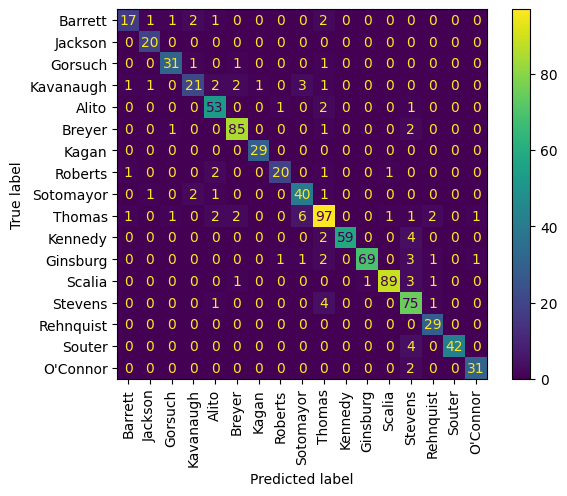

In [20]:
metrics.plot_confusion(opinions_test['label'],res, label2id)

In [21]:
metrics.print_metrics(opinions_test['author'],[id2label[i] for i in res])


-------------------- Key Metrics --------------------

Accuracy: 0.90
Balanced Accuracy: 0.89

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.90
Macro Recall: 0.89
Macro F1-score: 0.89

Weighted Precision: 0.90
Weighted Recall: 0.90
Weighted F1-score: 0.90

--------------- Classification Report ---------------

              precision    recall  f1-score   support

       Alito       0.85      0.93      0.89        57
     Barrett       0.85      0.71      0.77        24
      Breyer       0.93      0.96      0.94        89
    Ginsburg       0.99      0.88      0.93        78
     Gorsuch       0.91      0.91      0.91        34
     Jackson       0.87      1.00      0.93        20
       Kagan       0.97      1.00      0.98        29
   Kavanaugh       0.81      0.66      0.72        32
     Kennedy       1.00      0.91      0.95        65
    O'Connor       0.94      0.94      0.94        33
   Rehnquist       0.85      1.00      0.92        29
  

In [22]:
list_test = [{"text":c} for c in par_test.text]
tokenized_case = train.tokenize_dataset(Dataset.from_list(list_test))
par_model_pred = trainer.predict(tokenized_case)
l = par_model_pred.predictions.argmax(axis=1)

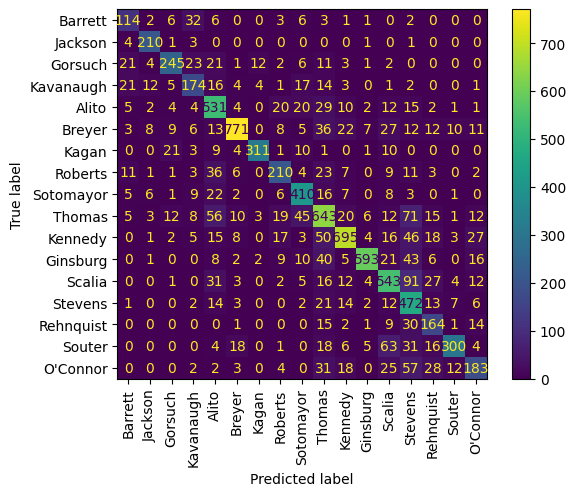

In [23]:
metrics.plot_confusion(par_test['label'],l, label2id)

In [24]:
metrics.print_metrics(par_test['author'],[id2label[i] for i in l])


-------------------- Key Metrics --------------------

Accuracy: 0.74
Balanced Accuracy: 0.73

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.73
Macro F1-score: 0.73

Weighted Precision: 0.76
Weighted Recall: 0.74
Weighted F1-score: 0.75

--------------- Classification Report ---------------

              precision    recall  f1-score   support

       Alito       0.68      0.80      0.73       662
     Barrett       0.60      0.65      0.62       176
      Breyer       0.92      0.80      0.86       960
    Ginsburg       0.94      0.78      0.86       756
     Gorsuch       0.80      0.70      0.74       352
     Jackson       0.84      0.95      0.89       220
       Kagan       0.94      0.84      0.88       371
   Kavanaugh       0.64      0.63      0.63       275
     Kennedy       0.84      0.76      0.80       910
    O'Connor       0.63      0.50      0.56       365
   Rehnquist       0.54      0.69      0.61       237
  